In [1]:
%run ../utils.py
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy
import logging
import requests
import time
import sys
import os.path
import os.path as osp
from codex import io as codex_io
from codex import config as codex_config
from skimage import exposure

init_session()

Using TensorFlow backend.


In [2]:
option_dict_conv = {"activation": "relu", "border_mode": "same"}
option_dict_bn = {"mode": 0, "momentum": 0.9}

def get_core(dim1, dim2):
    x = keras.layers.Input(shape=(dim1, dim2, 1))

    a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
    a = keras.layers.BatchNormalization(**option_dict_bn)(a)

    a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
    a = keras.layers.BatchNormalization(**option_dict_bn)(a)

    y = keras.layers.MaxPooling2D()(a)

    b = keras.layers.Convolution2D(128, 3, 3, **option_dict_conv)(y)
    b = keras.layers.BatchNormalization(**option_dict_bn)(b)

    b = keras.layers.Convolution2D(128, 3, 3, **option_dict_conv)(b)
    b = keras.layers.BatchNormalization(**option_dict_bn)(b)

    y = keras.layers.MaxPooling2D()(b)

    c = keras.layers.Convolution2D(256, 3, 3, **option_dict_conv)(y)
    c = keras.layers.BatchNormalization(**option_dict_bn)(c)

    c = keras.layers.Convolution2D(256, 3, 3, **option_dict_conv)(c)
    c = keras.layers.BatchNormalization(**option_dict_bn)(c)

    y = keras.layers.MaxPooling2D()(c)

    d = keras.layers.Convolution2D(512, 3, 3, **option_dict_conv)(y)
    d = keras.layers.BatchNormalization(**option_dict_bn)(d)

    d = keras.layers.Convolution2D(512, 3, 3, **option_dict_conv)(d)
    d = keras.layers.BatchNormalization(**option_dict_bn)(d)

    # UP

    d = keras.layers.UpSampling2D()(d)

    y = keras.layers.merge.concatenate([d, c])

    e = keras.layers.Convolution2D(256, 3, 3, **option_dict_conv)(y)
    e = keras.layers.BatchNormalization(**option_dict_bn)(e)

    e = keras.layers.Convolution2D(256, 3, 3, **option_dict_conv)(e)
    e = keras.layers.BatchNormalization(**option_dict_bn)(e)

    e = keras.layers.UpSampling2D()(e)

    y = keras.layers.merge.concatenate([e, b])

    f = keras.layers.Convolution2D(128, 3, 3, **option_dict_conv)(y)
    f = keras.layers.BatchNormalization(**option_dict_bn)(f)

    f = keras.layers.Convolution2D(128, 3, 3, **option_dict_conv)(f)
    f = keras.layers.BatchNormalization(**option_dict_bn)(f)

    f = keras.layers.UpSampling2D()(f)

    y = keras.layers.merge.concatenate([f, a])

    y = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(y)
    y = keras.layers.BatchNormalization(**option_dict_bn)(y)

    y = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(y)
    y = keras.layers.BatchNormalization(**option_dict_bn)(y)

    return [x, y]

def get_model_3_class(dim1, dim2, activation="softmax"):
    [x, y] = get_core(dim1, dim2)

    y = keras.layers.Convolution2D(3, 1, 1, **option_dict_conv)(y)

    if activation is not None:
        y = keras.layers.Activation(activation)(y)

    model = keras.models.Model(x, y)

    return model

def unet_initialize(input_shape):
    # create model

    dim1, dim2 = input_shape

    # build model
    model = get_model_3_class(dim1, dim2)

    # load weights
    weights_filename = '/tmp/cache/unet-checkpoint.hdf5'

    if not os.path.exists(weights_filename):
        cache_directory = os.path.dirname(weights_filename)
        if not os.path.exists(cache_directory):
            os.makedirs(os.path.dirname(weights_filename))

        # Download the weights
        print("Downloading model weights to: {:s}".format(weights_filename))
        model_id = "1I9j4oABbcV8EnvO_ufACXP9e4KyfHMtE"

        download_file_from_google_drive(model_id, weights_filename)

    model.load_weights(weights_filename)

    return model

def unet_classify(model, input_image):
    dim1, dim2 = input_image.shape

    images = input_image.reshape((-1, dim1, dim2, 1))

    images = images.astype(numpy.float32)
    images = images - numpy.min(images)
    images = images.astype(numpy.float32) / numpy.max(images)

    start = time.time()
    pixel_classification = model.predict(images, batch_size=1)
    end = time.time()
    print('UNet segmentation took {} seconds '.format(end - start))

    return pixel_classification[0, :, :, :]

# https://stackoverflow.com/a/39225272
def download_file_from_google_drive(id, destination):
    url = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(url, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {
            'id': id,
            'confirm': token
        }
        response = session.get(url, params=params, stream=True)

    save_response_content(response, destination)
    
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None


def save_response_content(response, destination):
    chunk_size = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(chunk_size):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

In [154]:
exp_name = '7-7-17-multicycle'
exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle')
exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], '7-7-17-multicycle-out-none', '1-Processor')
nuc_cyc = 0
nuc_ch = 0
mem_cyc = 2
mem_ch = 1
best_z = 4
crop = [slice(0, 512), slice(0, 512)]
tile_file = 'reg001_X01_Y01.tif'

# #exp_name = '20180614_D23_RepA_Tcell_CD4-CD8-DAPI_5by5'
# exp_name = '20180614_D22_RepA_Tcell_CD4-CD8-DAPI_5by5'
# exp_conf_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'config')
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'nodeconv')
# nuc_cyc = 0
# nuc_ch = 0
# best_z = 15
# #crop = [slice(0, 512), slice(0, 512)]
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'reg001_X02_Y01.tif'

# exp_name = '20180607_D21_activated_Tcells'
# exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', exp_name)
# exp_data_dir = osp.join(os.environ['CODEX_DATA_DIR'], exp_name, 'output', 'v01', 'processor', 'tile')
# nuc_cyc = 0
# nuc_ch = 0
# mem_cyc = 0
# mem_ch = 2
# best_z = 14
# crop = [slice(None, None), slice(None, None)]
# tile_file = 'R001_X001_Y001.tif'

In [155]:
exp_conf = codex_config.load(exp_conf_dir)

In [156]:
tile = codex_io.read_tile(osp.join(exp_data_dir, tile_file), exp_conf)
tile = tile[:, :, :, crop[0], crop[1]]
tile.shape, tile.dtype

/lab/repos/codex/python/pipeline/codex/io.py:91: UserWarning: ImageJ tags do not contain "axes" property (file = /lab/data/7-7-17-multicycle-out-none/1-Processor/reg001_X01_Y01.tif, tags = * ImageJ: 1.51g
* channels: 4
* frames: 8
* hyperstack: True
* images: 288
* loop: False
* luts: [array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12
* max: 65535.0
* min: 438.0
* mode: composite
* ranges: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
* slices: 9)
  warnings.warn('ImageJ tags do not contain "axes" property (file = {}, tags = {})'.format(file, tags))


((8, 9, 4, 512, 512), dtype('uint16'))

In [157]:
if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

In [158]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
#filters.rank.median(img_nuc, morphology.square(3))
# plt.imshow(img_nuc)
# plt.gcf().set_size_inches(12, 12)

In [159]:
input_shape = tile.shape[-2:]
input_shape

(512, 512)

In [160]:
model = unet_initialize(input_shape)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation=

In [161]:
img = unet_classify(model, img_nuc)
img.shape

UNet segmentation took 1.1039960384368896 seconds 


(512, 512, 3)

In [162]:
# plt.imshow(img)
# plt.gcf().set_size_inches(12, 12)

In [163]:
%%time
from codex.cytometry import cytometer
model_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'models', 'nuclei', 'v0.3')
model_path = osp.join(model_dir, 'nuclei_model.h5')
cytom = cytometer.Cytometer2D(img_nuc.shape + (1,), model_path).initialize()

CPU times: user 5.62 s, sys: 121 ms, total: 5.74 s
Wall time: 5.69 s


In [164]:
img_seg, img_pred, img_bin = cytom.segment(img_nuc[np.newaxis])

In [165]:
img_pred.shape

(1, 512, 512, 3)

In [166]:
img_pred[0].min(), img_pred[0].max()

(0.26905367, 0.9994056)

In [167]:
img_seg.shape

(1, 2, 512, 512)

In [172]:
img[..., 0].min(), img[..., 0].max()

(5.589522e-07, 0.99997616)

20180607_D21_activated_Tcells


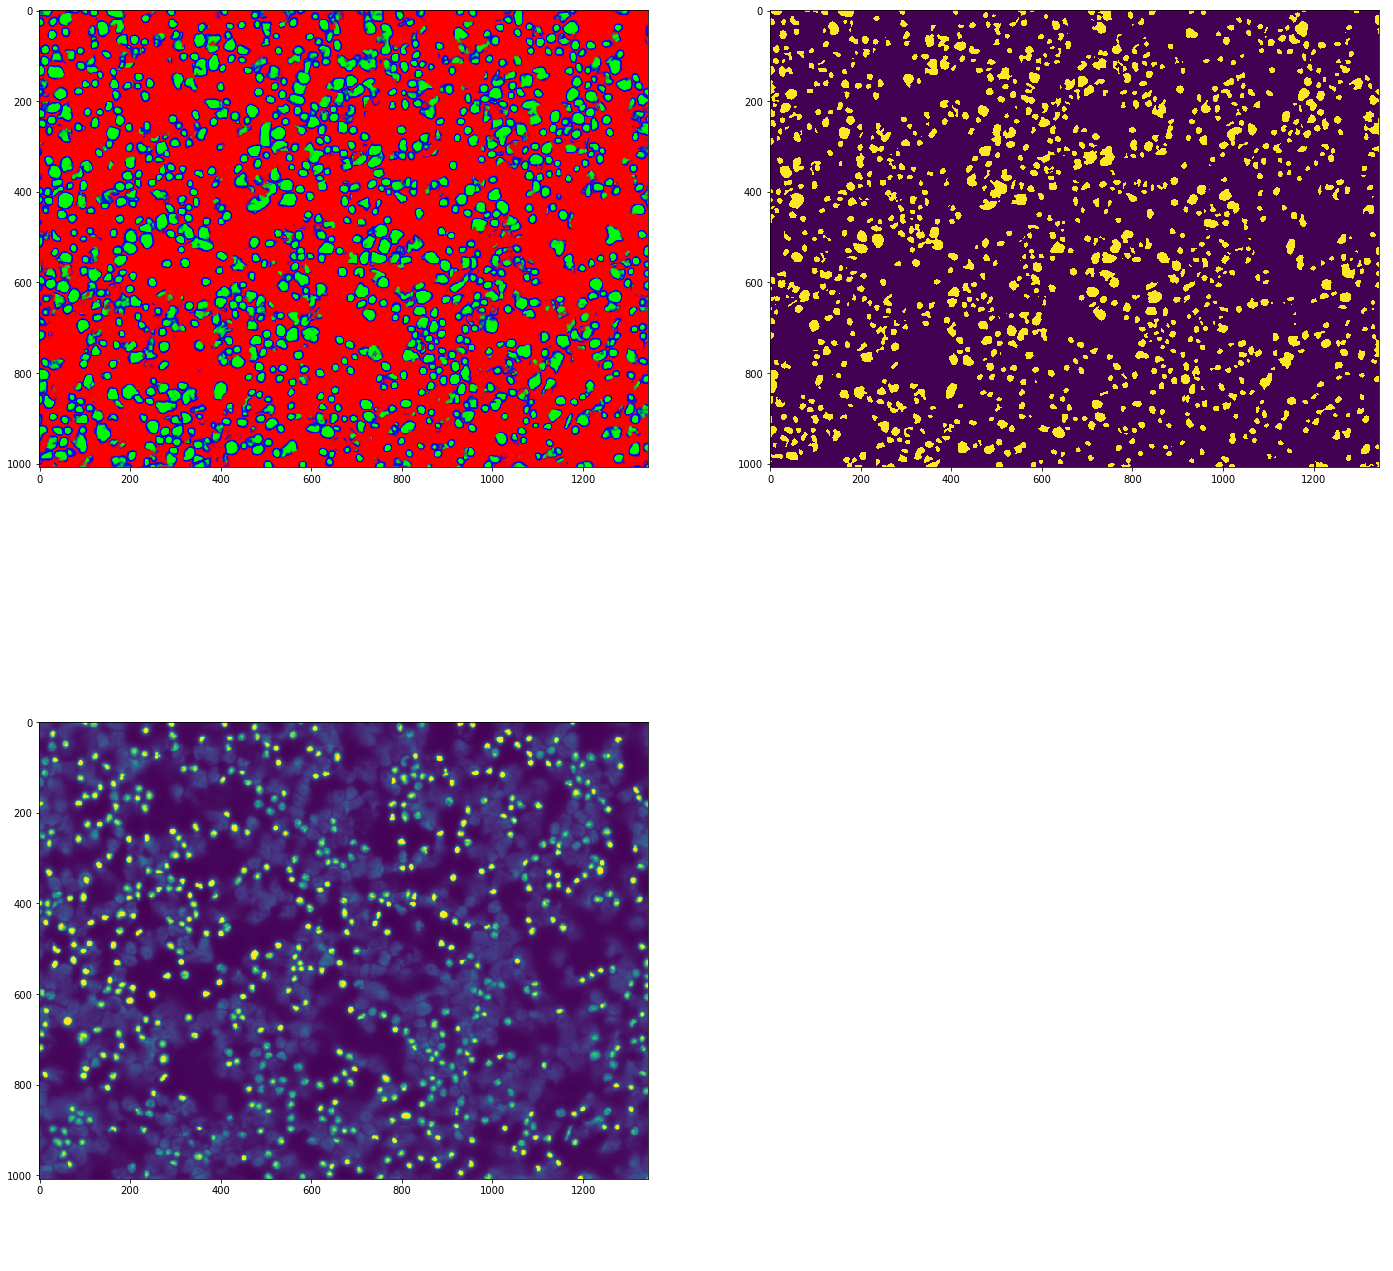

In [153]:
print(exp_name)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img)
ax[0, 1].imshow(img_seg[0, 1].clip(0, 1))
ax[1, 0].imshow(img_nuc)
ax[1, 1].axis('off')
plt.gcf().set_size_inches(24, 24)

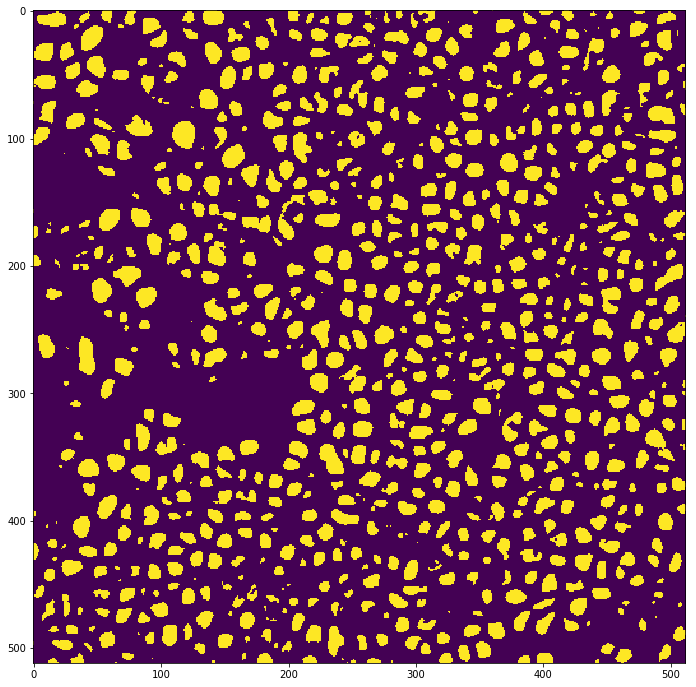

In [178]:
plt.imshow(img[..., 1] > .9)
plt.gcf().set_size_inches(12, 12)

7-7-17-multicycle


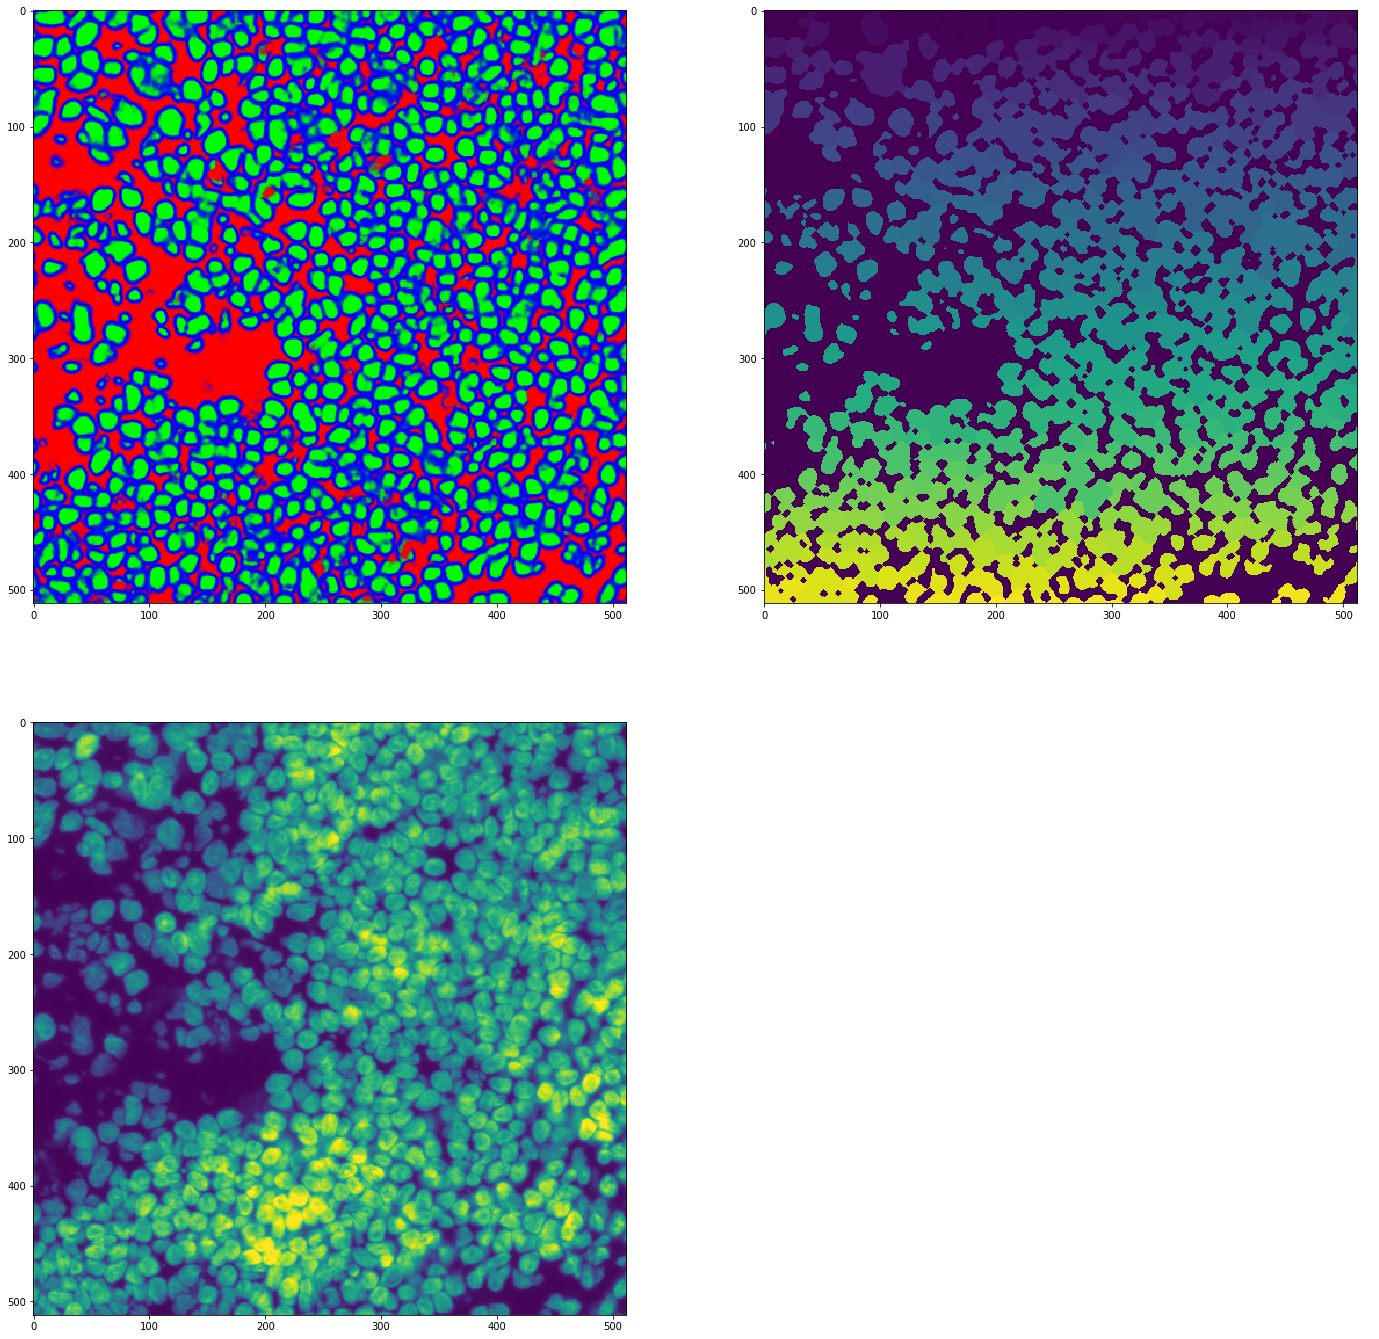

In [173]:
print(exp_name)
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(img)
ax[0, 1].imshow(img_seg[0, 1])#.clip(0, 1))
ax[1, 0].imshow(img_nuc)
ax[1, 1].axis('off')
plt.gcf().set_size_inches(24, 24)